In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk.corpus

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load Train dataset
trainFile = 'train2.tsv'
testFile = 'test2.tsv'
valFile = 'val2.tsv'


In [3]:
# add header to all three datasets
traindata = pd.read_csv(trainFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
traindata.name = 'Training Data'

testdata = pd.read_csv(testFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
testdata.name = 'Testing Data'

valdata = pd.read_csv(valFile, delimiter='\t', encoding='utf-8', names=
                        ["json ID", "label", "statement", "subject", "speaker", "job title", "state", "party",
                         "barely true", "false", "half true", "mostly true", "pants on fire", "los", "justification"])
valdata.name = 'Validation Data'

In [4]:
# Display few rows of traindata

traindata.head()

,json ID,label,statement,subject,speaker,job title,state,party,barely true,false,half true,mostly true,pants on fire,los,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [5]:
# Drop unnecessary columns from traindata, testdata and val
traindata= traindata.drop(columns=['json ID', 'subject', 'party', 'los','job title','state','speaker','justification'])
testdata =testdata.drop(columns=['json ID', 'subject', 'party', 'los','job title','state','speaker','justification'])
valdata =valdata.drop(columns=['json ID', 'subject', 'party', 'los','job title','state','speaker','justification'])


In [6]:
# Rearrange columns
columns_order = ['statement', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'label']
traindata = traindata[columns_order]

columns_order = ['statement', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'label']
testdata = testdata[columns_order]

columns_order = ['statement', 'barely true', 'false', 'half true', 'mostly true', 'pants on fire', 'label']
valdata = valdata[columns_order]

In [7]:
# Data Analysis
traindata.head(3)

,statement,barely true,false,half true,mostly true,pants on fire,label
0,Says the Annies List political group supports ...,0.0,1.0,0.0,0.0,0.0,false
1,When did the decline of coal start? It started...,0.0,0.0,1.0,1.0,0.0,half-true
2,"Hillary Clinton agrees with John McCain ""by vo...",70.0,71.0,160.0,163.0,9.0,mostly-true


In [8]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10240 entries, 0 to 10239
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   statement      10240 non-null  object 
 1   barely true    10238 non-null  float64
 2   false          10238 non-null  float64
 3   half true      10238 non-null  float64
 4   mostly true    10238 non-null  float64
 5   pants on fire  10238 non-null  float64
 6   label          10240 non-null  object 
dtypes: float64(5), object(2)
memory usage: 640.0+ KB


In [9]:
traindata.describe()

,barely true,false,half true,mostly true,pants on fire
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000
mean,11.533210,13.286482,17.133718,16.434265,6.201407
std,18.973764,24.112936,35.846511,36.151688,16.128927
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [10]:
testdata.head(3)

,statement,barely true,false,half true,mostly true,pants on fire,label
0,Building a wall on the U.S.-Mexico border will...,30,30,42,23,18,true
1,Wisconsin is on pace to double the number of l...,2,1,0,0,0,false
2,Says John McCain has done nothing to help the ...,63,114,51,37,61,false


In [11]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1267 entries, 0 to 1266
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   statement      1267 non-null   object
 1   barely true    1267 non-null   int64 
 2   false          1267 non-null   int64 
 3   half true      1267 non-null   int64 
 4   mostly true    1267 non-null   int64 
 5   pants on fire  1267 non-null   int64 
 6   label          1267 non-null   object
dtypes: int64(5), object(2)
memory usage: 79.2+ KB


In [12]:
testdata.describe()

,barely true,false,half true,mostly true,pants on fire
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,11.770324,13.465667,17.566693,16.912391,6.016575
std,18.980496,23.956307,36.109290,36.499879,15.059981
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,1.000000
75%,12.000000,17.000000,15.000000,14.000000,6.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [13]:
valdata.head()

,statement,barely true,false,half true,mostly true,pants on fire,label
0,We have less Americans working now than in the...,1,0,1,0,0,barely-true
1,"When Obama was sworn into office, he DID NOT u...",11,43,8,5,105,pants-fire
2,Says Having organizations parading as being so...,0,1,1,1,0,false
3,Says nearly half of Oregons children are poor.,0,1,1,1,0,half-true
4,On attacks by Republicans that various program...,70,71,160,163,9,half-true


In [14]:
valdata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1284 entries, 0 to 1283
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   statement      1284 non-null   object
 1   barely true    1284 non-null   int64 
 2   false          1284 non-null   int64 
 3   half true      1284 non-null   int64 
 4   mostly true    1284 non-null   int64 
 5   pants on fire  1284 non-null   int64 
 6   label          1284 non-null   object
dtypes: int64(5), object(2)
memory usage: 80.2+ KB


In [15]:
valdata.describe()

,barely true,false,half true,mostly true,pants on fire
count,1284.000000,1284.000000,1284.000000,1284.000000,1284.000000
mean,11.804517,13.832555,17.225078,16.595794,6.881620
std,19.021708,24.546884,35.622818,35.966699,17.597474
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.750000,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,1.000000
75%,12.000000,17.000000,13.000000,12.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [16]:
# Get shape of each dataset
print(traindata.shape)
print(testdata.shape)
print(valdata.shape)

(10240, 7)
(1267, 7)
(1284, 7)


In [17]:
# function to check distribution of labels
def check_dist(dataset):
  sns.countplot(x='label', data=traindata, palette='hls')

In [18]:
asd = pd.DataFrame(traindata['label'])

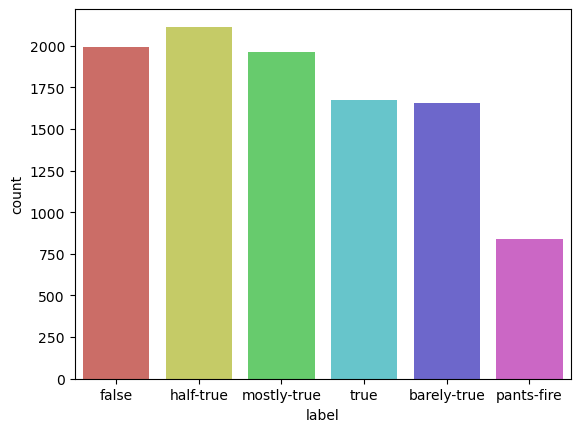

In [19]:
check_dist(traindata)

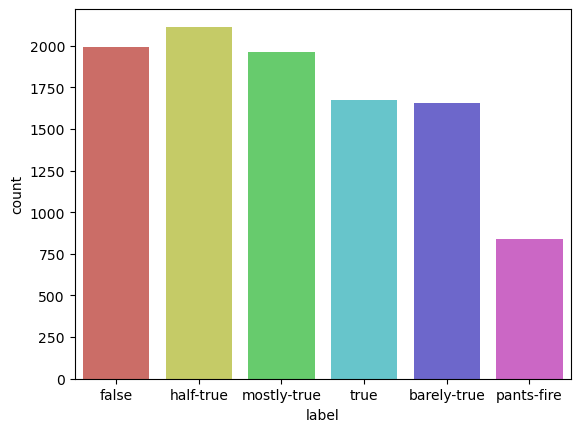

In [20]:
check_dist(testdata)

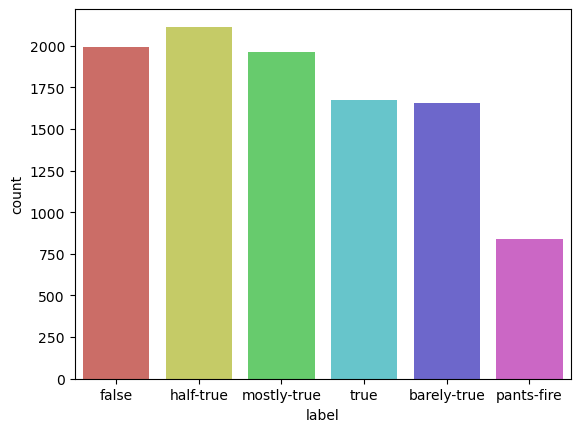

In [21]:
check_dist(valdata)

Deal with Missing Values

In [22]:
# Missing values in all datasets

print("Missing values in traindata are:\n\n",traindata.isnull().sum(),"\n")
print("Missing values in testdata are:\n\n",testdata.isnull().sum(),"\n")
print("Missing values in valdata are:\n",valdata.isnull().sum())

Missing values in traindata are:

 statement        0
barely true      2
false            2
half true        2
mostly true      2
pants on fire    2
label            0
dtype: int64 

Missing values in testdata are:

 statement        0
barely true      0
false            0
half true        0
mostly true      0
pants on fire    0
label            0
dtype: int64 

Missing values in valdata are:
 statement        0
barely true      0
false            0
half true        0
mostly true      0
pants on fire    0
label            0
dtype: int64


In [23]:
# Fill missing values with the median of each column
traindata = traindata.fillna(traindata[['barely true', 'false', 'half true', 'mostly true', 'pants on fire']].median())

# Verify if missing values are handled
print(traindata.isnull().sum())


statement        0
barely true      0
false            0
half true        0
mostly true      0
pants on fire    0
label            0
dtype: int64


In [24]:
# Check for duplicate rows
duplicates = traindata[traindata.duplicated()]
# Print duplicate rows
print(f'Number of duplicate rows in train data: {duplicates.shape[0]}')

duplicates = testdata[testdata.duplicated()]
# Print duplicate rows
print(f'Number of duplicate rows in test data: {duplicates.shape[0]}')

duplicates = valdata[valdata.duplicated()]
# Print duplicate rows
print(f'Number of duplicate rows in val data: {duplicates.shape[0]}')

Number of duplicate rows in train data: 2
Number of duplicate rows in test data: 0
Number of duplicate rows in val data: 0


Drop Duplicate Rows

In [25]:
# Drop duplicate rows from the dataset
traindata.drop_duplicates(inplace=True)

# Print the number of duplicate rows removed
print(f'Number of duplicate rows: {duplicates.shape[0]}')


Number of duplicate rows: 0


Value Counts

In [26]:
# Value counts for the label column in each dataset
print("Value counts for 'label' in Training Data:")
print(traindata['label'].value_counts())

Value counts for 'label' in Training Data:
label
half-true      2113
false          1994
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64


In [27]:
print("Value counts for 'label' in Testing Data:")
print(testdata['label'].value_counts())

Value counts for 'label' in Testing Data:
label
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: count, dtype: int64


In [28]:
print("Value counts for 'label' in Validation Data:")
print(valdata['label'].value_counts())

Value counts for 'label' in Validation Data:
label
false          263
mostly-true    251
half-true      248
barely-true    237
true           169
pants-fire     116
Name: count, dtype: int64


In [29]:
# Define the mapping dictionary
label_dict = {
    'half-true': 1,
    'false': 0,
    'mostly-true': 1,
    'true': 1,
    'barely-true': 0,
    'pants-fire': 0
}

# Apply the mapping directly to each dataset
traindata['binary_label'] = traindata['label'].map(label_dict)
valdata['binary_label'] = valdata['label'].map(label_dict)
testdata['binary_label'] = testdata['label'].map(label_dict)

In [30]:
# Print binary_label column of Anydataset to check mapping
print(valdata[['label', 'binary_label']].head(7))

         label  binary_label
0  barely-true             0
1   pants-fire             0
2        false             0
3    half-true             1
4    half-true             1
5        false             0
6         true             1


Value Counts for Binary Label

In [31]:
print(traindata['binary_label'].value_counts())
print(valdata['binary_label'].value_counts())
print(testdata['binary_label'].value_counts())

binary_label
1    5751
0    4487
Name: count, dtype: int64
binary_label
1    668
0    616
Name: count, dtype: int64
binary_label
1    714
0    553
Name: count, dtype: int64


Checking Statement text

In [32]:
traindata['statement'][9798]

'John McCain would "reduce oversight of health insurance."'

In [33]:
testdata['statement'][359]

'Says it probably costs more than $300,000 to run for a seat on the Pedernales Electric Cooperative board of directors.'

In [34]:
valdata['statement'][903]

'The Democrats health care reform law is agovernment takeover of health care.'

Text Preprocessing

Lowercase

In [35]:
# Convert the 'statement' column to lowercase in all three datasets
traindata['statement'] = traindata['statement'].str.lower()
testdata['statement'] = testdata['statement'].str.lower()
valdata['statement'] = valdata['statement'].str.lower()

print("\nTraining Data:")
print(traindata['statement'].head())


Training Data:
0    says the annies list political group supports ...
1    when did the decline of coal start? it started...
2    hillary clinton agrees with john mccain "by vo...
3    health care reform legislation is likely to ma...
4    the economic turnaround started at the end of ...
Name: statement, dtype: object


Remove Punctuation

In [36]:
import string

# Create a translation table for removing punctuation
translator = str.maketrans('', '', string.punctuation)

# Apply the punctuation removal to the 'statement' column in all three datasets
traindata['statement'] = traindata['statement'].apply(lambda text: text.translate(translator))
testdata['statement'] = testdata['statement'].apply(lambda text: text.translate(translator))
valdata['statement'] = valdata['statement'].apply(lambda text: text.translate(translator))

# Display the last few rows

print("\nTraining Data:")
print(traindata['statement'].tail())


Training Data:
10235    there are a larger number of shark attacks in ...
10236    democrats have now become the party of the atl...
10237    says an alternative to social security that op...
10238    on lifting the us cuban embargo and allowing t...
10239    the department of veterans affairs has a manua...
Name: statement, dtype: object


Lemmatization

In [37]:
# We dont apply removing stopwords because our data is already in this form
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the words in the 'statement' column
traindata['statement'] = traindata['statement'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))
testdata['statement'] = testdata['statement'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))
valdata['statement'] = valdata['statement'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))

# Verify the changes
print(traindata['statement'].tail(5))

10235    there are a larger number of shark attack in f...
10236    democrat have now become the party of the atla...
10237    say an alternative to social security that ope...
10238    on lifting the u cuban embargo and allowing tr...
10239    the department of veteran affair ha a manual o...
Name: statement, dtype: object


In [38]:
traindata.head()

,statement,barely true,false,half true,mostly true,pants on fire,label,binary_label
0,say the annies list political group support th...,0.0,1.0,0.0,0.0,0.0,false,0
1,when did the decline of coal start it started ...,0.0,0.0,1.0,1.0,0.0,half-true,1
2,hillary clinton agrees with john mccain by vot...,70.0,71.0,160.0,163.0,9.0,mostly-true,1
3,health care reform legislation is likely to ma...,7.0,19.0,3.0,5.0,44.0,false,0
4,the economic turnaround started at the end of ...,15.0,9.0,20.0,19.0,2.0,half-true,1


Normalize or Scale Numeric Columns

In [39]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the numeric columns in all datasets
numeric_columns = ['barely true', 'false', 'half true', 'mostly true', 'pants on fire']
traindata[numeric_columns] = scaler.fit_transform(traindata[numeric_columns])
testdata[numeric_columns] = scaler.transform(testdata[numeric_columns])
valdata[numeric_columns] = scaler.transform(valdata[numeric_columns])

# Check the scaled data
print(valdata[numeric_columns].head())

   barely true     false  half true  mostly true  pants on fire
0    -0.555033 -0.550897  -0.450020    -0.454520      -0.384432
1    -0.027945  1.232536  -0.254734    -0.316206       6.125866
2    -0.607741 -0.509422  -0.450020    -0.426857      -0.384432
3    -0.607741 -0.509422  -0.450020    -0.426857      -0.384432
4     3.081871  2.393842   3.985769     4.054512       0.173593


Rename Column

In [40]:
# Rename the 'statement' column to 'text'
traindata = traindata.rename(columns={'statement': 'text','binary_label':'target'})
testdata = testdata.rename(columns={'statement': 'text','binary_label':'target'})
valdata = valdata.rename(columns={'statement': 'text','binary_label':'target'})

WordCloud

Word Cloud for Training Data:


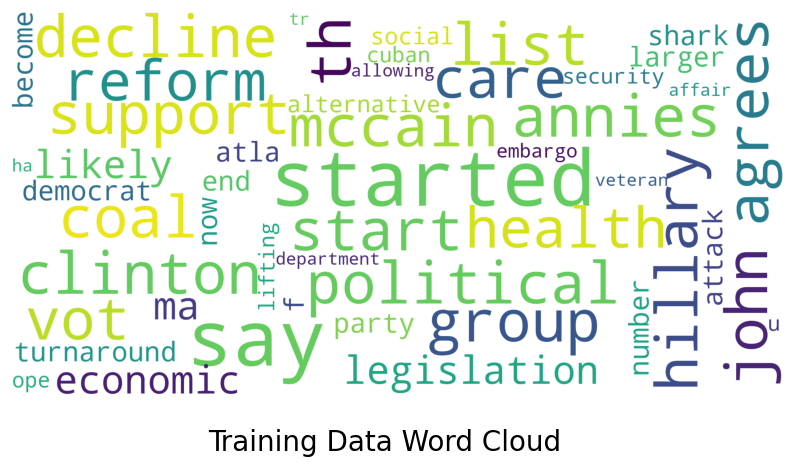

In [41]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define the stopwords set
stopwords = set(STOPWORDS)

# Define the function to generate a word cloud
def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40,
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

# Generate word clouds for traindata, testdata, and valdata
print("Word Cloud for Training Data:")
show_wordcloud(traindata['text'], title='Training Data Word Cloud')

Word Cloud for Testing Data:


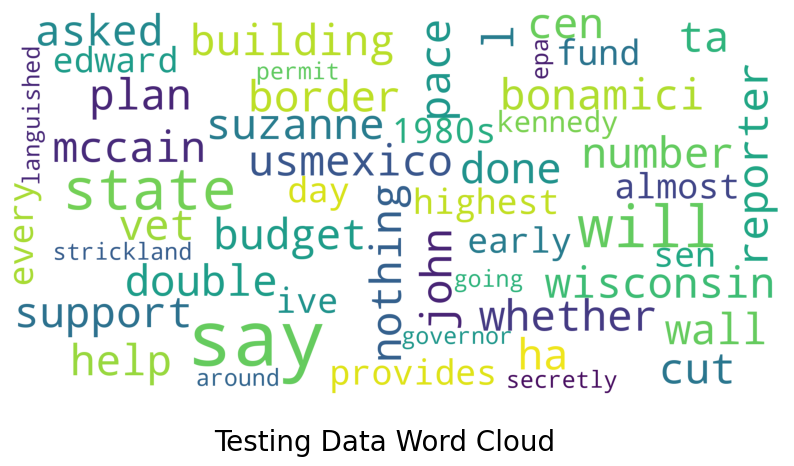

In [42]:
print("Word Cloud for Testing Data:")
show_wordcloud(testdata['text'], title='Testing Data Word Cloud')


In [43]:
traindata.head()

,text,barely true,false,half true,mostly true,pants on fire,label,target
0,say the annies list political group support th...,-0.607741,-0.509422,-0.477918,-0.454520,-0.384432,false,0
1,when did the decline of coal start it started ...,-0.607741,-0.550897,-0.450020,-0.426857,-0.384432,half-true,1
2,hillary clinton agrees with john mccain by vot...,3.081871,2.393842,3.985769,4.054512,0.173593,mostly-true,1
3,health care reform legislation is likely to ma...,-0.238780,0.237131,-0.394224,-0.316206,2.343693,false,0
4,the economic turnaround started at the end of ...,0.182890,-0.177621,0.080043,0.071073,-0.260426,half-true,1


In [44]:
# Create a new dataframe with only the selected columns
traindata = traindata[['text', 'target']]
testdata = testdata[['text', 'target']]
valdata = valdata[['text', 'target']]

df = pd.concat([traindata, testdata, valdata], ignore_index=True)
print(df)

                                                    text  target
0      say the annies list political group support th...       0
1      when did the decline of coal start it started ...       1
2      hillary clinton agrees with john mccain by vot...       1
3      health care reform legislation is likely to ma...       0
4      the economic turnaround started at the end of ...       1
...                                                  ...     ...
12784  for the first time in more than a decade impor...       1
12785  say donald trump ha bankrupted his company not...       1
12786  john mccain and george bush have absolutely no...       1
12787  a new poll show 62 percent support the preside...       0
12788  no one claim the report vindicating new jersey...       0

[12789 rows x 2 columns]


In [46]:
# Save df to a CSV file
df.to_csv('LIAR_Cleaned_data.csv', index=False)